# Keras CIFAR-10 dataset solution

In [32]:
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import model_from_json
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import scikitplot as skplt

### Load the dataset

In [33]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

### Dataset exploration
We want to get a good understanding of the dataset. Here we visualize some of the data and gather some usefull stats.

Number of training examples: 50000
Number of testing examples: 10000
Number of classes: 10
Image shape: (32, 32, 3)
Image data type: uint8


<BarContainer object of 10 artists>

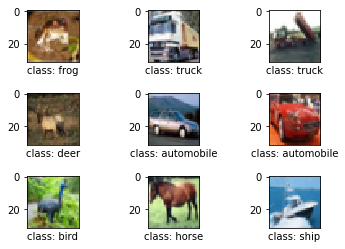

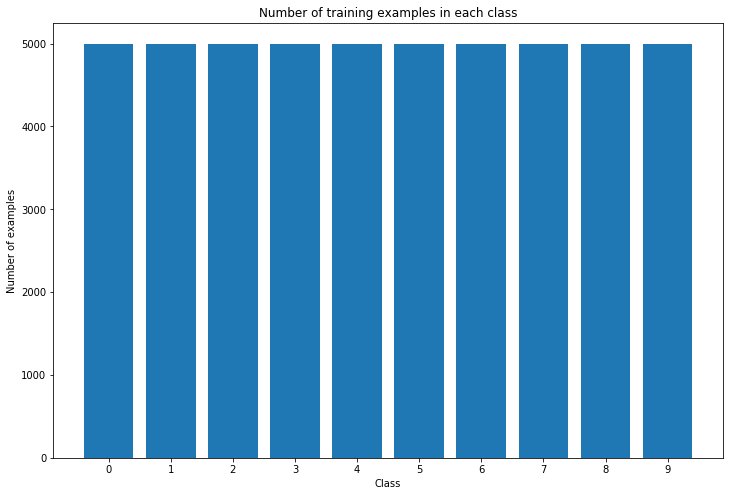

In [34]:
# Visualize
fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

class_to_label =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(train_images[i])

    # Name of the true class.
    cls_true_name = class_to_label[train_labels[i][0]]
    xlabel = "class: {0}".format(cls_true_name)

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])
    
num_classes = np.unique(train_labels).shape[0]
print("Number of training examples:", train_images.shape[0])
print("Number of testing examples:", test_images.shape[0])
print("Number of classes:", num_classes)
print("Image shape:", train_images[0].shape)
print("Image data type:", train_images.dtype)
    
reshaped_labels = [class_num[0] for class_num in train_labels]
class_distribution = Counter(reshaped_labels)
x = range(10)
y = [class_distribution[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of training examples in each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, y)

## Pre processing

#### Transform labels to a binary class matrix

In [35]:
num_classes = 10
# Convert class vectors to binary class matrices.
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

## Data augmentation

We use data augmentation to create subtle differences in the dataset. This can be used to increase the amount of data - adding augmented copies of entries in the dataset, or simply to create more variations - decreasing the overfitting problem. 

Here we only use data augmentation on entries in the dataset, without adding more data. This had an effect on the overfitting of our model (positively)

In [36]:
# Data agumentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_images)

#### Normalization

We perform pixel-wise normalization to make all features have a uniform scale. This helps remove biases in the model (eucledian distance in higher-dimensional space)

In [37]:
# Normalization
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [38]:
# Train weights
def fit_save_network(network, epochs, name=None):
    ''' Fit and save a network, or load from disk '''
    print()
    network.summary()
    if not os.path.isfile('{}.csv'.format(str(name))) or not os.path.isfile('{}.h5'.format(str(name))):
        csv_logger = CSVLogger('{}.csv'.format(str(name)), 
                               separator=',', 
                               append=False)
        network.fit(train_images, train_labels,
                  batch_size=128,
                  epochs=epochs,
                  validation_split = 0.25,
                  callbacks = [csv_logger])
        # serialize weights to HDF5
        network.save_weights('{}.h5'.format(str(name)))
        print('Saved model to disk')
        history = network.history.history
    else:
        log_data = pd.read_csv('{}.csv'.format(str(name)), 
                               sep=',', 
                               engine='python')
        network.load_weights('{}.h5'.format(str(name)))
        print('Loaded model from disk')
        history = log_data

    test_loss, test_acc = network.evaluate(test_images, test_labels)
    print('test_acc:', test_acc)

    return network, history

Saving the model to disk

We save the model to disk, this way we don't have to retrain every single time we rerun this program

We set the number of epochs we want to train for, and also the batch size we want to use.

The model is evaulated after each epoch on the validation set.


## Best MNIST on the CIFAR10 dataset

In [39]:
network = models.Sequential()

network.add(layers.Flatten(input_shape=train_images.shape[1:]))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 10
network, history = fit_save_network(network, epochs, 'mnist_old')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               786688    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________

In [40]:
score = network.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (network.metrics_names[1], score[1]*100))

acc: 40.62%


## Evaluation

The model does quite poorly on the CIFAR10 dataset. This is because the pictures contain a lot of features that cannot be detected without adding convolutions to the network. Evaluating each pixel value atomically does not maintain the translation invariance etc..

10000/10000 [==============================] - 1s 99us/step
The final loss on the test set is: 1.6837360740661622
The final accuracy on the test set is: 0.4062


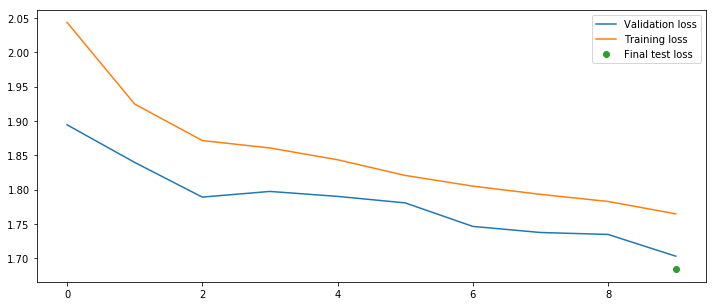

In [41]:
final_loss, final_accuracy = network.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

As we can see here there is no sign of overfitting. We could increase the epoch size to improve the accuracy, but considering that there are no convolutions in this model we don't expect great results

### Further analysis
These two functions allows us to find precision and recall, also visualizes it quite nicely. 

In [42]:
def plot_classification_report(plotMat, classes):
    ''' Plots the classification report from scikit-learn as a heatmap '''
    title='Precision-recall report'
    plt.figure(figsize=(10, 5))
    plt.imshow(plotMat, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    y_tick_marks = np.arange(3)
    x_tick_marks = np.arange(len(classes))
    plt.yticks(y_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.xticks(x_tick_marks, classes)
    #plt.tight_layout()
    plt.xlabel('Classes')
    plt.ylabel('Measures')
    plt.show()

In [43]:
def visualize_precision_recall(network, epochs):
    ''' Visualizes precision-recall in as a heatmap and showing the ROC-curve
    ''' 
    #test_score = history.decision_function(test_images)
    pred = network.predict(test_images, batch_size=128, verbose=1)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(test_labels, axis=1),
            predicted)
    probas = network.predict_proba(test_images)
    print(report)

    # need to do this again to get the dictionary for plots :S
    report = classification_report(np.argmax(test_labels, axis=1), predicted, output_dict=True)

    plotMat = []
    classes =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    precision = []
    recall = []
    f1 = []
    for k, v in report.items():
        precision.append(v.get('precision'))
        recall.append(v.get('recall'))
        f1.append(v.get('f1-score'))
    plotMat.append(precision[:10])
    plotMat.append(recall[:10])
    plotMat.append(f1[:10])
    plot_classification_report(plotMat, classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(),
            probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(12, 8))
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

### Visualize precision and recall, ROC

10000/10000 [==============================] - 1s 57us/step
              precision    recall  f1-score   support

           0       0.47      0.46      0.46      1000
           1       0.59      0.44      0.51      1000
           2       0.29      0.10      0.15      1000
           3       0.28      0.18      0.22      1000
           4       0.28      0.50      0.36      1000
           5       0.49      0.22      0.31      1000
           6       0.34      0.68      0.46      1000
           7       0.45      0.48      0.47      1000
           8       0.48      0.55      0.51      1000
           9       0.50      0.45      0.48      1000

   micro avg       0.41      0.41      0.41     10000
   macro avg       0.42      0.41      0.39     10000
weighted avg       0.42      0.41      0.39     10000



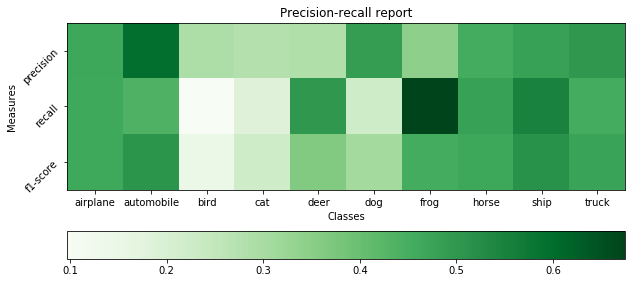

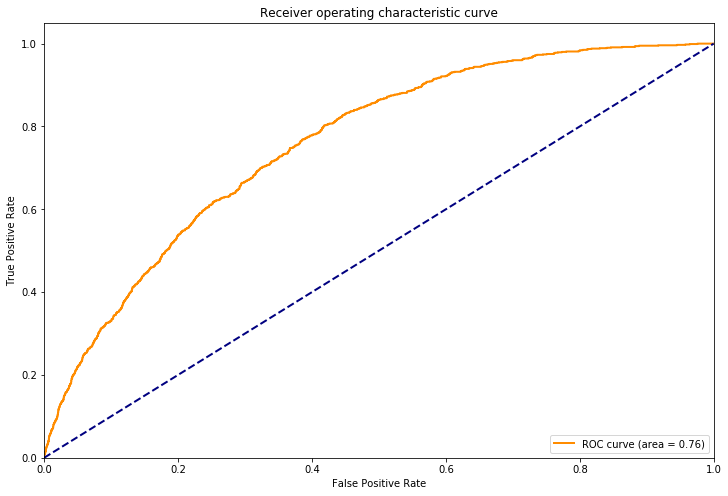

In [44]:
visualize_precision_recall(network, epochs)

We can see that the model is struggling with the more complex classes: birds, cats, dogs. For some reason, the recall on frogs is very high. 

The model is clearly not complex enough to be able to extract the correct features from the images. 

## Simple model, >70% accuracy

We use a very simple model (88k paramteres) to get 70% accuracy. There are 4 convolution layers, using a 3x3 maxpooling kernel. There is also dropout from each layer - reducing the chance of overfitting. 
We use 'same'-padding - no downsampling is needed here, maxpooling takes care of this. 

The max pooling layers extract higher level features in the image while providing translation invariance. It also reduces the input size of the next layer in the network. This is essential for reducing the amount of inputs for the classication-model (FCNN at the end of the model)

Our classifier is a FCNN with a single input-layer that gets 2304 inputs from the convolution-layers. There are no hidden layers - but rather a single output layer using the softmax activation function. The number of classes matches the number of ouputs. This creates a probability distrubtion over all the output classes. 


In [45]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:]))
model.add(Activation('relu'))
x = Conv2D(32, (3, 3))
model.add(x)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 64)        18496     
__________

We use a very low learning rate: we found this to be the better than a higher one by training the model several times and evaluating the loss graphs and accuracy graphs in the end.

The validation loss during training was too unstable to use early stopping. Instead we trained for over 100 epochs and used the graphs to figure out the ideal number of epochs that maximized the accuracy and at the same time keeping the bias of the model as low as possible. 60 epochs was then found to be a good figure.

The model and training history is saved and loaded from disk.. 

In [46]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
epochs = 60
model, history = fit_save_network(model, epochs, 'simplenew60')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 64)        18496     
_________

We achieve an accuracy of just over 70%

In [47]:
score = model.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 72.09%


10000/10000 [==============================] - 5s 549us/step
The final loss on the test set is: 0.812207894706726
The final accuracy on the test set is: 0.7209


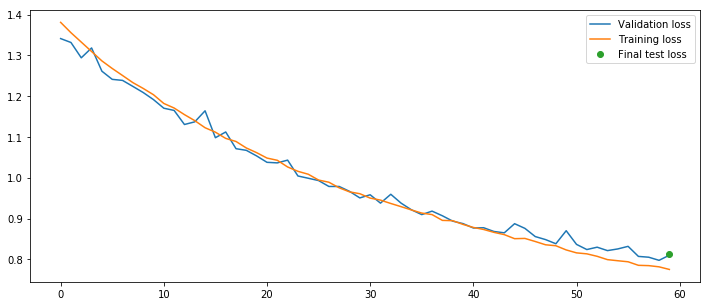

In [48]:
final_loss, final_accuracy = model.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

As we can see, there is close to no bias in this model. Most likely due to the use of data augmentation and the fact that the model is very simple. 

# Complex model, ~85% accuracy

In the complex model we tried to add more convolutions in order to extract even more higher level features. 

We use the eLu-activation function as it increases the rate of learning and helps push the gradient closer to the unit natural gradient. It proved to be an improvement over ReLu.
Weight-decay is used to decrease the chance of overfitting - it shrinks all the coefficients closer to zero. 

Batch normalization is also used in every layer to decrease overfitting.

Maxpooling is used, just as in the simple model. 
We also use dropout to further decrease the chance of overfitting. This is crucial (as seen in MNIST), specially with this many trainable parameters (300k). 

The amount of trainable parameters is still relatively low compared to other CNNs. This is because our classifier did not need to be very complex. It is a single input layer, taking 2048 features from the convolution-layers. This is feeded directly to the output layer, using softmax on 10 ouput nodes (same amount as the number of classes). This again gives us a probability distribution over the classes.

In [49]:
# Heavy best model:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

epochs = 50
model, history = fit_save_network(model, epochs, "best")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________

## Evaluation

We get an accuracy of ~85%, which is quite good.

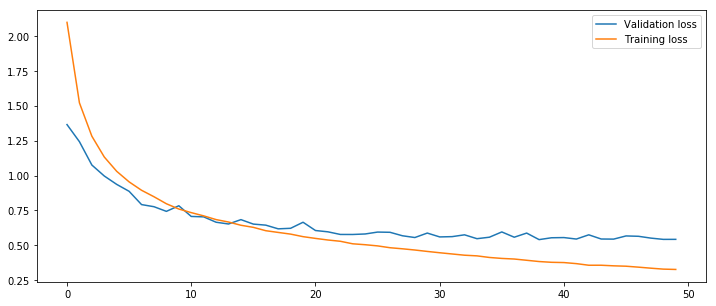

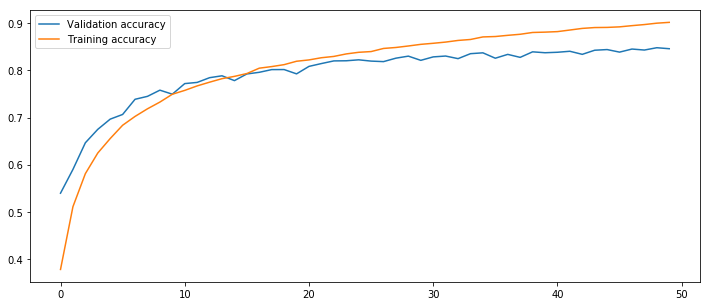

10000/10000 [==============================] - 26s 3ms/step
The final loss on the test set is: 0.5430690180301666
The final accuracy on the test set is: 0.8456


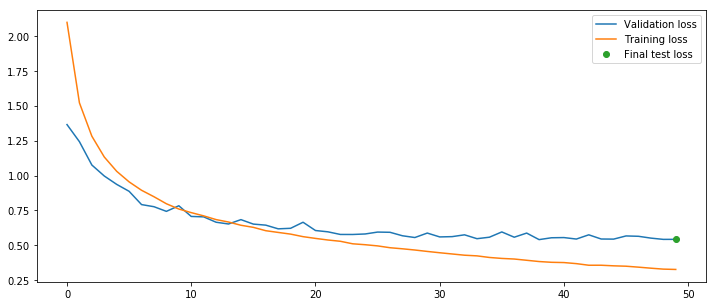

In [50]:
''' Visulize loss and acurracy for a network '''
# plot losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.legend()
plt.show()

# plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history['val_acc'], label='Validation accuracy')
plt.plot(history['acc'], label='Training accuracy')
plt.legend()
plt.show()

final_loss, final_accuracy = model.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

We can see that the validation loss is still decreasing slightly. We used the same method for determining the amount of epochs as in the simple model. The final test loss is exactly the same as the validation loss, which is very good. 

This lack of overfitting is most likely a result of the data augmenation, bath normalization, weight decay and dropout. 

## More evaluation

10000/10000 [==============================] - 22s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.93      0.92      0.92      1000
           2       0.78      0.80      0.79      1000
           3       0.73      0.68      0.70      1000
           4       0.80      0.85      0.82      1000
           5       0.76      0.76      0.76      1000
           6       0.87      0.91      0.89      1000
           7       0.91      0.89      0.90      1000
           8       0.88      0.93      0.91      1000
           9       0.93      0.88      0.91      1000

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



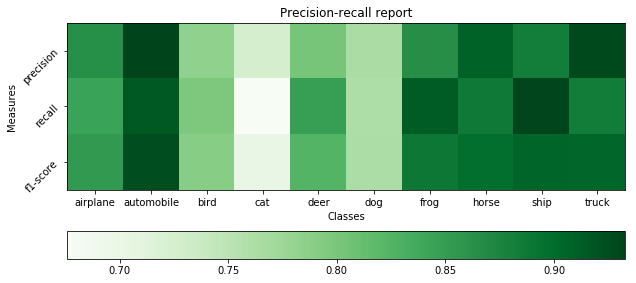

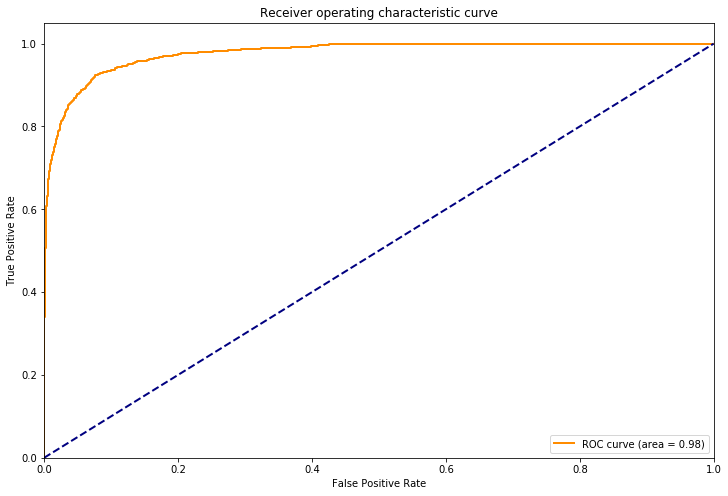

In [51]:
visualize_precision_recall(model, epochs)

From the heatmap we see that we have a very good precision-recall, compared to the final accuracy. 

It is clear that the worst classes are cats and dogs. This might be due to these classes requiring significantly more detail to be able to classify. Since the model is not very complex (only 300k params), it might be usefull to remove the cat and dog classes from the dataset and traina separate model for those classes. 
Automobiles are classified quite well, and seems to be at the limit of what is possible. It is probaly no advantageous to have two classes that require substantially different levels of detail in the same model.

However, the true-positive-rate over false-positive-rate curve indicates a very good model - the integral of the curve is close to 1 (=0.98).


## Implementation of a known model on CIFAR-10

In [49]:
vgg = keras.applications.vgg16.VGG16(include_top=False,
weights='imagenet',
input_shape=train_images.shape[1:])
for layer in vgg.layers[:-2]:
    layer.trainable = False
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [50]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
epochs = 40
model, history = fit_save_network(model, epochs, 'known')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 14,719,818
Trainable params: 2,364,938
Non-trainable params: 12,354,880
_________________________________________________________________
Train on 37500 samples, validate on 12500 samples
Epoch 1/40
37500/37500 [==============================] - 56s 1ms/step - loss: 1.3525 - acc: 0.5365 - val_loss: 1.1975 - val_acc: 0.5862
Epoch 2/40
37500/37500 [==============================] - 54s 1ms/step - loss: 1.1054 - acc: 0.6180 - val_loss: 1.0685 - val_acc: 0.6290
Epoch 3/40
37500/37500 [==============================] - 55s

10000/10000 [==============================] - 10s 963us/step
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      1000
           1       0.79      0.75      0.77      1000
           2       0.62      0.64      0.63      1000
           3       0.54      0.52      0.53      1000
           4       0.63      0.64      0.63      1000
           5       0.57      0.62      0.59      1000
           6       0.72      0.71      0.72      1000
           7       0.87      0.61      0.72      1000
           8       0.80      0.79      0.79      1000
           9       0.75      0.71      0.73      1000

   micro avg       0.68      0.68      0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



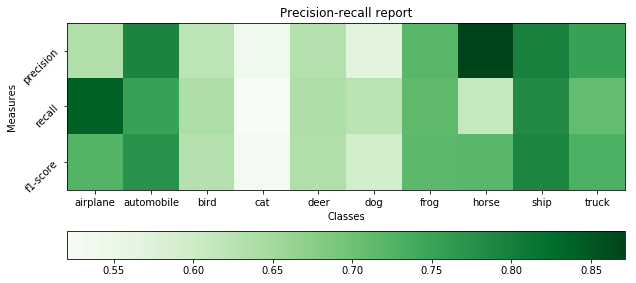

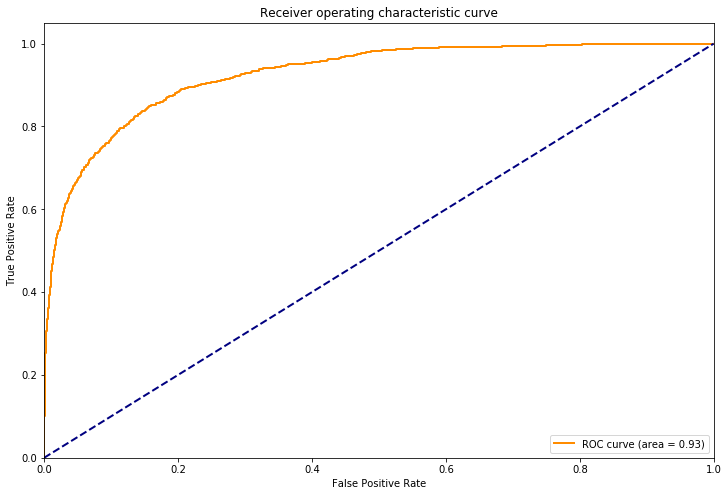

In [51]:
visualize_precision_recall(model, epochs)

The model performs poorly when considering the fact that it uses over to million parameters.
It struggles especially on detecting animals compared to our best CIFAR10 model. Neural networks generally have a constriction that they are very domain specific, meaning that they do not generalise well. Considering that vgg model is trained on a dataset consisting of millions of images and around 1000 classes, this domain is far greater than that of the CIFAR10 dataset. 

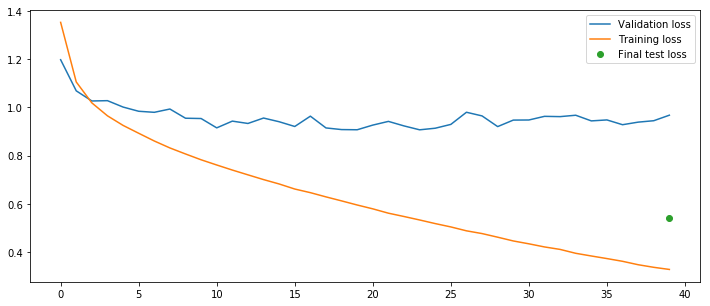

In [52]:
# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

The model converges quite early, most likely because it has already been trained quite extensively before this.
